In [1]:
!pip install -U keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
path = "/content/drive/MyDrive/BTC-USD/BTC-USD.csv"
df=pd.read_csv(path)
# df.head()

,Date,symbol,Open,High,Low,Close,Volume BTC,Volume
0,2022-03-01,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,2022-02-28,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,2022-02-27,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,2022-02-26,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,2022-02-25,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


927/927 - 19s - loss: 0.0039 - 19s/epoch - 20ms/step
52/52 [==============================] - 1s 10ms/step


<ipython-input-4-4931e87d4740>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


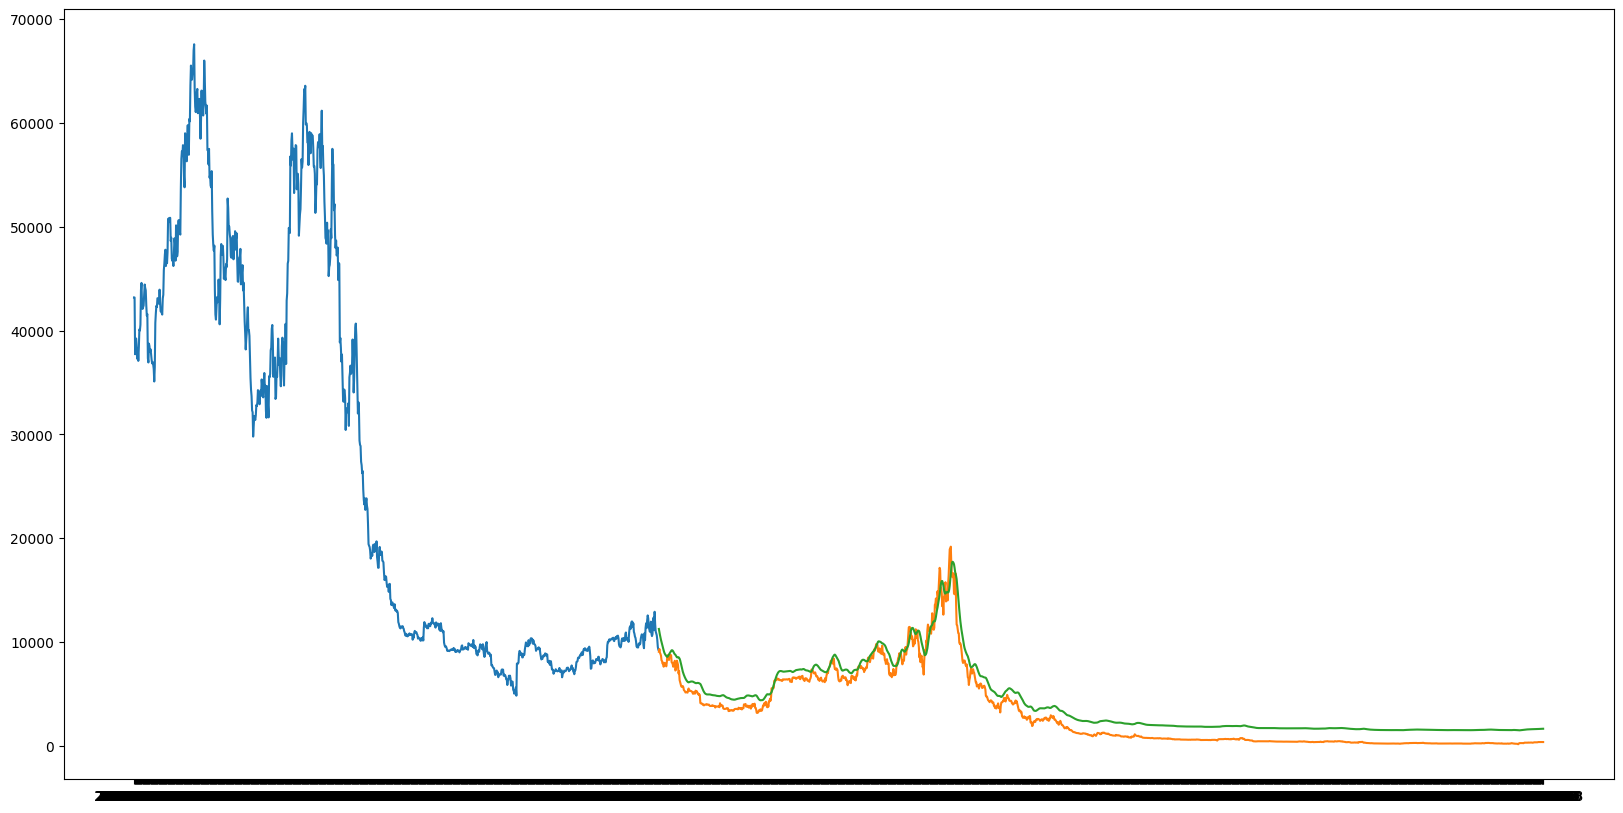

In [4]:
# path = "/content/drive/MyDrive/BTC-USD/BTC-USD.csv"
# df=pd.read_csv(path)

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]


new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))




lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

lstm_model.save("saved_lstm_model.h5")

train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [5]:
!pip install jupyter-dash #this is the Dash library adapted for Jupyter notebooks
# !pip install -q dash-bootstrap-components transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.1 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.0
    Uninstalling Werkzeug-2.3.0:
      Successfully uninstalled Werkzeug-2.3.0


In [6]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

<ipython-input-6-add1b3bebb2f>:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-6-add1b3bebb2f>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [7]:
# app = dash.Dash()
# server = app.server
app = JupyterDash(__name__)

def LSTM_Prediction(data_csv):
    df=pd.read_csv(data_csv)

    df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
    df.index=df['Date']

    data=df.sort_index(ascending=True,axis=0)
    new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
    for i in range(0,len(data)):
        new_dataset["Date"][i]=data['Date'][i]
        new_dataset["Close"][i]=data["Close"][i]
    new_dataset['Date'] = pd.to_numeric(pd.to_datetime(new_dataset['Date']))

    scaler=MinMaxScaler(feature_range=(0,1))
    final_dataset=new_dataset.values
    train_data=final_dataset[0:987,:]
    valid_data=final_dataset[987:,:]
    new_dataset.index=new_dataset.Date
    new_dataset.drop("Date",axis=1,inplace=True)
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(final_dataset)
    x_train_data,y_train_data=[],[]
    for i in range(60,len(train_data)):
        x_train_data.append(scaled_data[i-60:i,0])
        y_train_data.append(scaled_data[i,0])

    x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
    x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

    lstm_model=Sequential()
    lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(1))
    inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
    inputs_data=inputs_data.reshape(-1,1)
    inputs_data=scaler.fit_transform(inputs_data)
    lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

    lstm_model.save(data_csv[-11:-4] + ".h5")

    X_test=[]
    for i in range(60,inputs_data.shape[0]):
        X_test.append(inputs_data[i-60:i,0])
    X_test=np.array(X_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    predicted_closing_price=lstm_model.predict(X_test)
    predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

    train_data=new_dataset[:987]
    valid_data=new_dataset[987:]
    train_data.index = pd.to_datetime(train_data.index)
    valid_data.index = pd.to_datetime(valid_data.index)
    valid_data['Predictions']=predicted_closing_price

    return train_data, valid_data

BTC_train, BTC_valid = LSTM_Prediction("/content/drive/MyDrive/BTC-USD/BTC-USD.csv")
ETH_train, ETH_valid = LSTM_Prediction("/content/drive/MyDrive/ETH-USD/ETH-USD.csv")
ADA_train, ADA_valid = LSTM_Prediction("/content/drive/MyDrive/ADA-USD/ADA-USD.csv")


927/927 - 25s - loss: 2.3311e-04 - 25s/epoch - 27ms/step
52/52 [==============================] - 1s 11ms/step


<ipython-input-7-75d41ff3d6a4>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


927/927 - 17s - loss: 0.0011 - 17s/epoch - 19ms/step
15/15 [==============================] - 1s 11ms/step


<ipython-input-7-75d41ff3d6a4>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


927/927 - 17s - loss: 4.3579e-04 - 17s/epoch - 19ms/step
33/33 [==============================] - 1s 14ms/step


<ipython-input-7-75d41ff3d6a4>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


In [11]:
app.layout = html.Div([

    html.H1("Cryptocurrencies Price Analysis Dashboard", style={"textAlign": "center"}),

    dcc.Tabs(id="tabs", children=[

        dcc.Tab(label='BTC-USD',children=[
            html.Div([
                html.H2("Actual Closing Price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=BTC_valid.index,
                                y=BTC_valid["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("LSTM Predicted Closing Price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=BTC_valid.index,
                                y=BTC_valid["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )
            ])
        ]),

        dcc.Tab(label='ETH-USD',children=[
            html.Div([
                html.H2("Actual Closing Price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=ETH_valid.index,
                                y=ETH_valid["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("LSTM Predicted Closing Price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=ETH_valid.index,
                                y=ETH_valid["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )
            ])
        ]),

        dcc.Tab(label='ADA-USD',children=[
            html.Div([
                html.H2("Actual Closing Price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=ADA_valid.index,
                                y=ADA_valid["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("LSTM Predicted Closing Price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=ADA_valid.index,
                                y=ADA_valid["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )
            ])
        ]),
    ])
])


if __name__=='__main__':
    app.run_server(mode='external')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



Dash app running on:


<IPython.core.display.Javascript object>